In [1]:
import alpaca_trade_api as alpaca
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')


In [3]:
# List of energy company tickers
energy_tickers = ['XOM', 'CVX', 'COP', 'EOG', 'PXD', 'SLB', 'PSX', 'MPC', 'VLO', 'HES', 'OXY', 'BKR', 'FANG', 'DVN', 'HAL']

# Set the time frame
timeframe = "30Min"

# Set the start and end dates for the data
start_date = "2022-01-01T00:00:00-00:00"
end_date = "2023-01-01T00:00:00-00:00"

# Dictionary to store stock data for each ticker
stock_data = {}

# Loop through each ticker and retrieve the data
for ticker in energy_tickers:
    df = alpaca_api.get_bars(ticker, timeframe, start_date, end_date).df
    df['SMA30'] = df['close'].rolling(window=30).mean()
    stock_data[ticker] = df

In [4]:
lookahead = 5
all_tickers_data = pd.DataFrame()

# Loop through each ticker and process the data
for ticker in energy_tickers:
    df = alpaca_api.get_bars(ticker, timeframe, start_date, end_date).df
    df['SMA30'] = df['close'].rolling(window=30).mean()
    df['closePct'] = df['close'].pct_change()
    df['Tstat30'] = (df['close'] - df['SMA30']) / df['close'].rolling(window=30).std()
    df = df.dropna()
    df['Ticker'] = ticker  # Add a column for the ticker symbol
    
    # Copy the DataFrame and reset the index
    dfCopy = df.copy()
    dfCopy = dfCopy.reset_index()
    dfCopy['signal'] = 0
    UpsideBreakout = False
    DownsideBreakout = False

'''Here's a breakdown of what the signals represent:

Upside Breakout (signal = 1): This signal is generated when the stock's price moves above its SMA30, indicating a potential upward trend or breakout. Traders might interpret this as a buy signal, expecting the price to continue rising.

Downside Breakout (signal = -1): This signal is generated when the stock's price falls below its SMA30, indicating a potential downward trend or breakout. Traders might interpret this as a sell signal, expecting the price to continue falling.

No Signal (signal = 0): This indicates that there is no significant breakout, and the stock's price is moving within the range of its SMA30.'''

    
    # Calculate signals
    for index, row in dfCopy.iterrows():
        if index < dfCopy['close'].idxmax() - lookahead:
            for x in range(lookahead):
                if x == 0:
                    y = 0
                else:
                    y = x - 1

                if dfCopy.loc[index + x, 'close'] > dfCopy.loc[index + x, 'SMA30'] and dfCopy.loc[index + y, 'close'] < dfCopy.loc[index + y, 'SMA30']:
                    UpsideBreakout = True
                    break

                if dfCopy.loc[index + x, 'close'] < dfCopy.loc[index + x, 'SMA30'] and dfCopy.loc[index + y, 'close'] > dfCopy.loc[index + y, 'SMA30']:
                    DownsideBreakout = True
                    break

        if UpsideBreakout:
            for x in range(lookahead):
                dfCopy.loc[index + x, 'signal'] = 1
            UpsideBreakout = False

        if DownsideBreakout:
            for x in range(lookahead):
                dfCopy.loc[index + x, 'signal'] = -1
            DownsideBreakout = False

    # Drop NaN values and create the target variable 'y'
    dfCopy = dfCopy.dropna()
    y = dfCopy['signal'].shift(-1)

    # Review the value counts
    print(f"Value counts for {ticker}:")
    print(y.value_counts())

    # Add the processed data to the combined DataFrame
    all_tickers_data = pd.concat([all_tickers_data, dfCopy])

# Save the combined data with signals to a CSV file
all_tickers_data.to_csv('all_tickers_data_with_signals.csv')



Value counts for XOM:
signal
 0.0    4566
 1.0    1392
-1.0    1353
Name: count, dtype: int64
Value counts for CVX:
signal
 0.0    4229
 1.0    1235
-1.0    1188
Name: count, dtype: int64
Value counts for COP:
signal
 0.0    3784
 1.0    1026
-1.0     999
Name: count, dtype: int64
Value counts for EOG:
signal
 0.0    3105
 1.0    1039
-1.0    1035
Name: count, dtype: int64
Value counts for PXD:
signal
 0.0    4312
 1.0     421
-1.0     404
Name: count, dtype: int64
Value counts for SLB:
signal
 0.0    4244
 1.0    1245
-1.0    1215
Name: count, dtype: int64
Value counts for PSX:
signal
 0.0    3148
 1.0    1008
-1.0     981
Name: count, dtype: int64
Value counts for MPC:
signal
 0.0    2960
 1.0    1046
-1.0     974
Name: count, dtype: int64
Value counts for VLO:
signal
 0.0    4492
 1.0     491
-1.0     475
Name: count, dtype: int64
Value counts for HES:
signal
 0.0    2802
-1.0     789
 1.0     782
Name: count, dtype: int64
Value counts for OXY:
signal
 0.0    5516
 1.0    1088
-1.0 

In [9]:
all_tickers_data

,timestamp,close,high,low,trade_count,open,volume,vwap,SMA30,closePct,Tstat30,Ticker,signal
0,2022-01-03 14:15:00+00:00,61.40,61.4000,61.300,20,61.30,336,61.377842,61.513763,-0.001301,-0.855590,XOM,1
1,2022-01-03 14:20:00+00:00,61.44,61.4400,61.390,19,61.39,835,61.413647,61.511763,0.000651,-0.537036,XOM,1
2,2022-01-03 14:25:00+00:00,61.24,61.3800,61.220,87,61.38,4637,61.284827,61.502097,-0.003255,-1.839776,XOM,1
3,2022-01-03 14:30:00+00:00,61.66,61.6645,61.210,4017,61.24,851866,61.322385,61.510763,0.006858,1.036820,XOM,1
4,2022-01-03 14:35:00+00:00,61.99,62.0201,61.665,3777,61.67,567721,61.873681,61.522097,0.005352,2.804482,XOM,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28091,2022-12-30 21:20:00+00:00,39.45,39.4500,39.200,2,39.20,5100,39.445098,39.122727,0.002541,1.904676,HAL,0
28092,2022-12-30 21:40:00+00:00,39.34,39.3400,39.340,2,39.34,479,39.341670,39.135227,-0.002788,1.179655,HAL,0
28093,2022-12-30 21:45:00+00:00,39.45,39.4500,39.450,1,39.45,500,39.450000,39.153227,0.002796,1.673062,HAL,0
28094,2022-12-30 21:50:00+00:00,39.35,39.3500,39.350,4,39.35,113,39.350000,39.165893,-0.002535,1.037712,HAL,0


In [1]:
import alpaca_trade_api as alpaca
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')

# List of energy company tickers
energy_tickers = ['XOM', 'CVX', 'COP', 'EOG', 'PXD', 'SLB', 'PSX', 'MPC', 'VLO', 'HES', 'OXY', 'BKR', 'FANG', 'DVN', 'HAL']

# Set the time frame
timeframe = "30Min"

# Set the start and end dates for the data
start_date = "2022-01-01T00:00:00-00:00"
end_date = "2023-01-01T00:00:00-00:00"

lookahead = 5
all_tickers_data = pd.DataFrame()

# Loop through each ticker and process the data
for ticker in energy_tickers:
    df = alpaca_api.get_bars(ticker, timeframe, start_date, end_date).df
    df['SMA30'] = df['close'].rolling(window=30).mean()
    df['closePct'] = df['close'].pct_change()
    df['Tstat30'] = (df['close'] - df['SMA30']) / df['close'].rolling(window=30).std()
    df = df.dropna()
    df['Ticker'] = ticker  # Add a column for the ticker symbol
    
    # Copy the DataFrame and reset the index
    dfCopy = df.copy()
    dfCopy = dfCopy.reset_index()
    dfCopy['timestamp'] = pd.to_datetime(dfCopy['timestamp'])
    dfCopy.set_index('timestamp', inplace=True)
    dfCopy['signal'] = 0
    UpsideBreakout = False
    DownsideBreakout = False

    # Calculate signals
    for index, row in dfCopy.iterrows():
     if index < dfCopy.index.max() - pd.Timedelta(minutes=lookahead * 5):  # Assuming 5-minute intervals
        for x in range(lookahead):
            if x == 0:
                y = 0
            else:
                y = x - 1

            next_index = index + pd.Timedelta(minutes=x * 5)  # Adjust the time delta for the next index
            prev_index = index + pd.Timedelta(minutes=y * 5)  # Adjust the time delta for the previous index

            if next_index in dfCopy.index and prev_index in dfCopy.index:
                if dfCopy.loc[next_index, 'close'] > dfCopy.loc[next_index, 'SMA30'] and dfCopy.loc[prev_index, 'close'] < dfCopy.loc[prev_index, 'SMA30']:
                    UpsideBreakout = True
                    break

                if dfCopy.loc[next_index, 'close'] < dfCopy.loc[next_index, 'SMA30'] and dfCopy.loc[prev_index, 'close'] > dfCopy.loc[prev_index, 'SMA30']:
                    DownsideBreakout = True
                    break

        if UpsideBreakout:
            for x in range(lookahead):
                dfCopy.loc[index + pd.Timedelta(minutes=x * 5), 'signal'] = 1
            UpsideBreakout = False

        if DownsideBreakout:
            for x in range(lookahead):
                dfCopy.loc[index + pd.Timedelta(minutes=x * 5), 'signal'] = -1
            DownsideBreakout = False


    # Prepare the data for training and testing
    dfCopy = dfCopy.dropna()
    y = dfCopy['signal'].shift(-1)
    y.index = pd.to_datetime(y.index)  # Ensure y's index is a datetime index
    X = dfCopy[['closePct', 'Tstat30']].dropna()

    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=60)

    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    training_end = X.index.max() - DateOffset(months=2)  # Use a more appropriate end date, e.g., 2 months before the max date in X
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]
    # Scale the features
    # Scale the features
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
# Drop NaN values from y_train and corresponding rows in X_train_scaled
    nan_mask_train = ~y_train.isnull().values
    X_train_scaled = X_train_scaled[nan_mask_train]
    y_train = y_train.dropna()
# Drop NaN values from y_test and corresponding rows in X_test_scaled
    nan_mask_test = ~y_test.isnull().values
    X_test_scaled = X_test_scaled[nan_mask_test]
    y_test = y_test.dropna()
# Train the SVM model
    model = svm.SVC(probability=True)
    model.fit(X_train_scaled, y_train)
# Make predictions
    predictions = model.predict(X_test_scaled)
# Generate classification report
    print(f"Classification report for {ticker}:")
    print(classification_report(y_test, predictions))
# Add the processed data to the combined DataFrame
    all_tickers_data = pd.concat([all_tickers_data, dfCopy])
# Save the combined data with signals to a CSV file
all_tickers_data.to_csv('all_tickers_data_with_signals.csv')



ValueError: The number of classes has to be greater than one; got 1 class

In [28]:
all_tickers_data

,close,high,low,trade_count,open,volume,vwap,SMA30,closePct,Tstat30,Ticker,signal
timestamp,,,,,,,,,,,,
2022-01-03 14:15:00+00:00,61.40,61.4000,61.300,20.0,61.30,336.0,61.377842,61.513763,-0.001301,-0.855590,XOM,1.0
2022-01-03 14:20:00+00:00,61.44,61.4400,61.390,19.0,61.39,835.0,61.413647,61.511763,0.000651,-0.537036,XOM,1.0
2022-01-03 14:25:00+00:00,61.24,61.3800,61.220,87.0,61.38,4637.0,61.284827,61.502097,-0.003255,-1.839776,XOM,1.0
2022-01-03 14:30:00+00:00,61.66,61.6645,61.210,4017.0,61.24,851866.0,61.322385,61.510763,0.006858,1.036820,XOM,1.0
2022-01-03 14:35:00+00:00,61.99,62.0201,61.665,3777.0,61.67,567721.0,61.873681,61.522097,0.005352,2.804482,XOM,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 21:20:00+00:00,39.45,39.4500,39.200,2.0,39.20,5100.0,39.445098,39.122727,0.002541,1.904676,HAL,0.0
2022-12-30 21:40:00+00:00,39.34,39.3400,39.340,2.0,39.34,479.0,39.341670,39.135227,-0.002788,1.179655,HAL,0.0
2022-12-30 21:45:00+00:00,39.45,39.4500,39.450,1.0,39.45,500.0,39.450000,39.153227,0.002796,1.673062,HAL,0.0


In [3]:
for ticker in energy_tickers:
    # Your existing code for processing the data goes here
    
    # Print the value counts for the current ticker
    print(f"Value counts for {ticker}:")
    print(y.value_counts())

Value counts for XOM:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for CVX:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for COP:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for EOG:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for PXD:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for SLB:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for PSX:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for MPC:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for VLO:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for HES:
signal
 0.0    15581
-1.0     4431
 1.0     4316
Name: count, dtype: int64
Value counts for OXY:
signal
 

In [4]:
import alpaca_trade_api as alpaca
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')

# List of energy company tickers
energy_tickers = ['XOM', 'CVX', 'COP', 'EOG', 'PXD', 'SLB', 'PSX', 'MPC', 'VLO', 'HES', 'OXY', 'BKR', 'FANG', 'DVN', 'HAL']

# Set the time frame
timeframe = "5Min"

# Set the start and end dates for the data
start_date = "2022-01-01T00:00:00-00:00"
end_date = "2023-01-01T00:00:00-00:00"

lookahead = 5
all_tickers_data = pd.DataFrame()# Loop through each ticker and process the data
for ticker in energy_tickers:
    df = alpaca_api.get_bars(ticker, timeframe, start_date, end_date).df
    df['SMA30'] = df['close'].rolling(window=30).mean()
    df['closePct'] = df['close'].pct_change()
    df['Tstat30'] = (df['close'] - df['SMA30']) / df['close'].rolling(window=30).std()
    df = df.dropna()
    df['Ticker'] = ticker  # Add a column for the ticker symbol
    
    # Copy the DataFrame and reset the index
    dfCopy = df.copy()
    dfCopy = dfCopy.reset_index()
    dfCopy['timestamp'] = pd.to_datetime(dfCopy['timestamp'])
    dfCopy.set_index('timestamp', inplace=True)
    dfCopy['signal'] = 0
    UpsideBreakout = False
    DownsideBreakout = False

    # Calculate signals
    for index, row in dfCopy.iterrows():
        if index < dfCopy.index.max() - pd.Timedelta(minutes=lookahead * 5):  # Assuming 5-minute intervals
            for x in range(lookahead):
                if x == 0:
                    y = 0
                else:
                    y = x - 1

                next_index = index + pd.Timedelta(minutes=x * 5)  # Adjust the time delta for the next index
                prev_index = index + pd.Timedelta(minutes=y * 5)  # Adjust the time delta for the previous index

                if next_index in dfCopy.index and prev_index in dfCopy.index:
                    if dfCopy.loc[next_index, 'close'] > dfCopy.loc[next_index, 'SMA30'] and dfCopy.loc[prev_index, 'close'] < dfCopy.loc[prev_index, 'SMA30']:
                        UpsideBreakout = True
                        break

                    if dfCopy.loc[next_index, 'close'] < dfCopy.loc[next_index, 'SMA30'] and dfCopy.loc[prev_index, 'close'] > dfCopy.loc[prev_index, 'SMA30']:
                        DownsideBreakout = True
                        break

            if UpsideBreakout:
                for x in range(lookahead):
                    dfCopy.loc[index + pd.Timedelta(minutes=x * 5), 'signal'] = 1
                UpsideBreakout = False

            if DownsideBreakout:
                for x in range(lookahead):
                    dfCopy.loc[index + pd.Timedelta(minutes=x * 5), 'signal'] = -1
                DownsideBreakout = False

    # Add the ticker symbol column
    dfCopy['Ticker'] = ticker

    # Prepare the data for training and testing
    dfCopy = dfCopy.dropna()
    y = dfCopy['signal'].shift(-1)
    y.index = pd.to_datetime(y.index)  # Ensure y's index is a datetime index
    X = dfCopy[['closePct', 'Tstat30']].dropna()

    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=60)

    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    training_end = X.index.max() - DateOffset(months=2)  # Use a more appropriate end date, e.g., 2 months before the max date in X
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    # Drop NaN values from y_train and corresponding rows in X_train_scaled
    nan_mask_train = ~y_train.isnull().values
    X_train_scaled = X_train_scaled[nan_mask_train]
    y_train = y_train.dropna()

    # Drop NaN values from y_test and corresponding rows in X_test_scaled
    nan_mask_test = ~y_test.isnull().values
    X_test_scaled = X_test_scaled[nan_mask_test]
    y_test = y_test.dropna()

    # Train the SVM model
    model = svm.SVC(probability=True)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    predictions = model.predict(X_test_scaled)

    # Generate classification report
    print(f"Classification report for {ticker}:")
    print(classification_report(y_test, predictions))

    # Add the processed data to the combined DataFrame
    all_tickers_data = pd.concat([all_tickers_data, dfCopy])

# Save the combined data with signals to a CSV file
all_tickers_data.to_csv('all_tickers_data_with_signals.csv')


Classification report for XOM:
              precision    recall  f1-score   support

        -1.0       0.43      0.08      0.13      1049
         0.0       0.66      0.97      0.79      3573
         1.0       0.50      0.11      0.18      1068

    accuracy                           0.65      5690
   macro avg       0.53      0.39      0.37      5690
weighted avg       0.59      0.65      0.55      5690

Classification report for CVX:
              precision    recall  f1-score   support

        -1.0       0.37      0.10      0.16       822
         0.0       0.69      0.96      0.80      3043
         1.0       0.43      0.10      0.17       837

    accuracy                           0.66      4702
   macro avg       0.50      0.39      0.38      4702
weighted avg       0.59      0.66      0.58      4702

Classification report for COP:
              precision    recall  f1-score   support

        -1.0       0.47      0.11      0.18       765
         0.0       0.69      0.97   

In [38]:
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_train:", np.unique(y_train))


Unique values in y_test: [-1.  0.  1.]
Unique values in y_train: [-1.  0.  1.]


In [39]:
y_train_binary = y_train.replace({-1: 0})
y_test_binary = y_test.replace({-1: 0})


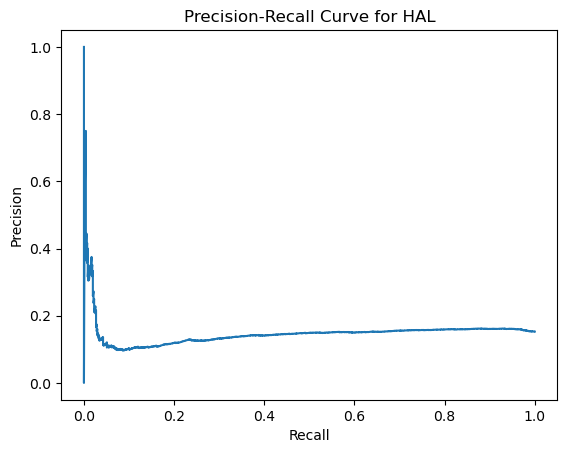

In [43]:
# Train the SVM model
model = svm.SVC(probability=True)
model.fit(X_train_scaled, y_train_binary)

# Get probabilities for the positive class
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {ticker}')
plt.show()

# Find the threshold with the highest F1 score
# Calculate F1 scores
# Calculate F1 scores, avoiding division by zero
f1_scores = np.zeros_like(precision)
non_zero_mask = (precision + recall) > 0
f1_scores[non_zero_mask] = 2 * (precision[non_zero_mask] * recall[non_zero_mask]) / (precision[non_zero_mask] + recall[non_zero_mask])
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs >= best_threshold).astype(int)


In [44]:
# Find the threshold with the highest F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]


In [45]:
print("Best Threshold:", best_threshold)
print("Index of Maximum Precision:", np.argmax(precision))


Best Threshold: 0.17444351315560275
Index of Maximum Precision: 4626


In [46]:
# Make predictions with the best threshold
y_pred = (y_probs >= best_threshold).astype(int)

# Generate the classification report
svm_testing_report = classification_report(y_test_binary, y_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.91      0.13      0.22      3919
         1.0       0.16      0.93      0.28       708

    accuracy                           0.25      4627
   macro avg       0.54      0.53      0.25      4627
weighted avg       0.80      0.25      0.23      4627



In [47]:
X_test

,closePct,Tstat30
timestamp,,
2022-10-31 11:10:00+00:00,-0.013066,-3.155444
2022-10-31 11:25:00+00:00,0.002817,-2.106856
2022-10-31 11:45:00+00:00,0.001404,-1.600762
2022-10-31 11:50:00+00:00,0.001403,-1.164344
2022-10-31 12:00:00+00:00,-0.009524,-2.930284
...,...,...
2022-12-30 21:20:00+00:00,0.002541,1.904676
2022-12-30 21:40:00+00:00,-0.002788,1.179655
2022-12-30 21:45:00+00:00,0.002796,1.673062


In [49]:
from sklearn.metrics import classification_report

# Get probabilities for the positive class
y_probs = model.predict_proba(X_test_scaled)[:, 1]


# Iterate over thresholds from 0.01 to 0.99
for x in range(1, 100, 1):
    threshold = float(x) / 100
    print("Threshold:", threshold)
    
    # Make predictions based on the current threshold
    y_pred = (y_probs >= threshold).astype(int)
    
    # Generate and print the classification report, setting zero_division to 0
    svm_testing_report = classification_report(y_test_binary, y_pred, zero_division=0)
    print(svm_testing_report)



Threshold: 0.01
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3919
         1.0       0.15      1.00      0.27       708

    accuracy                           0.15      4627
   macro avg       0.08      0.50      0.13      4627
weighted avg       0.02      0.15      0.04      4627

Threshold: 0.02
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3919
         1.0       0.15      1.00      0.27       708

    accuracy                           0.15      4627
   macro avg       0.08      0.50      0.13      4627
weighted avg       0.02      0.15      0.04      4627

Threshold: 0.03
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3919
         1.0       0.15      1.00      0.27       708

    accuracy                           0.15      4627
   macro avg       0.08      0.50      0.13      4627
weighted avg       0.02   

In [1]:
# Scatter plot for each ticker comparing with SPY
for ticker in energy_tickers:
    ticker_df = all_tickers_data[all_tickers_data['Ticker'] == ticker]
    for i in range(30, 61, 5):  # Different periods (30, 35, ..., 60)
        merged_df = pd.concat([ticker_df['closePct'], spy_df['SPY_close_pct']], axis=1, join='inner').dropna()
        merged_df = merged_df.pct_change(i).dropna()

        corr = merged_df['closePct'].corr(merged_df['SPY_close_pct'])
        if abs(corr) >= 0.1:
            plt.figure(figsize=(8, 6))
            plt.scatter(merged_df['closePct'], merged_df['SPY_close_pct'])
            plt.title(f'Scatterplot: {ticker} vs SPY (Period: {i} days)')
            plt.xlabel(f'{ticker} % Change')
            plt.ylabel('SPY % Change')
            plt.show()
            print(f'Correlation between {ticker} and SPY over {i} days: {corr}\n')



KeyboardInterrupt

